# Basic machine learning pipeline

In [1]:

# import packages

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay

from sklearn.model_selection import GridSearchCV

In [2]:
#| label: importdata
# Import data
df = pd.read_csv("../data/UV_pilot.csv")

# Split features and target
X = df.loc[:,"4000":"403"]
y = df.loc[:,"Exposed"]

# Split into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, stratify=y, test_size=0.2)

In [3]:
#| label: modellist
model_dict = {
    "LR": LogisticRegression(),
    "SVM": SVC(),
    "RF": RandomForestClassifier(),
}

In [4]:
#| label: modelcomparison
results = []
names = []
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.3, random_state=7)

for key, model in model_dict.items():
    pipe = Pipeline([('scaler', StandardScaler(with_std=False)), ('model', model)])

    cv_results = cross_val_score(pipe, X_train, y_train, cv=sss, scoring="accuracy")
    results.append(cv_results)
    names.append(key)
    print(f'Accuracy using {key} is {cv_results.mean():.2f} ± {cv_results.std():.2f}')



Accuracy using LR is 0.53 ± 0.08
Accuracy using SVM is 0.45 ± 0.04
Accuracy using RF is 0.69 ± 0.09


[Text(1, 0, 'LR'), Text(2, 0, 'SVM'), Text(3, 0, 'RF')]

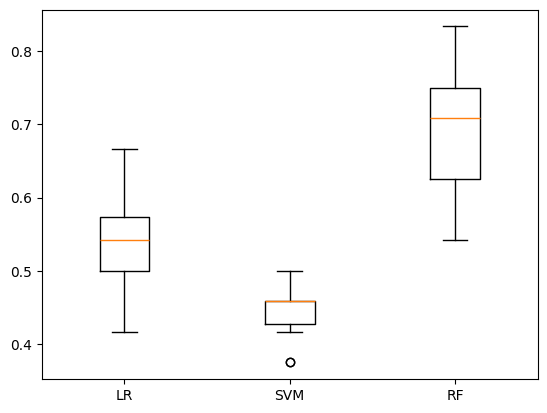

In [5]:
#| label: modelcomparisonplot
fig, ax = plt.subplots()
ax.boxplot(results)
ax.set_xticklabels(names)


In [8]:
#| label: parameters
# create a dictionary with different hyperparameters and the values you want to test

param_grid = {'model__max_depth': [5, 6],
            'model__min_samples_split': [2, 3, 4]}

# create the new pipleine with the model we choose to optimize
pipe = Pipeline([('scaler', StandardScaler(with_std=False)), ('model', RandomForestClassifier(class_weight='balanced'))])


In [9]:
#| label: optimization
search = GridSearchCV(pipe, param_grid, n_jobs=2)
search.fit(X_train, y_train)
print(f"Best parameter (CV score={search.best_score_:.2f})")
print(search.best_params_)

Best parameter (CV score=0.68)
{'model__max_depth': 6, 'model__min_samples_split': 2}


In [10]:
#| label: bestestimator
search.best_estimator_

Pipeline(steps=[('scaler', StandardScaler(with_std=False)),
                ('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=6))])

In [11]:
#| label: prediction
optimized_model = search.best_estimator_
optimized_model.fit(X_train, y_train)
y_pred = optimized_model.predict(X_test)

In [12]:
y_pred

array(['YES', 'NOU', 'YES', 'NOU', 'YES', 'NOU', 'NOU', 'NOU', 'NOU',
       'NOU', 'NOU', 'NOU', 'NOU', 'NOU', 'NOU', 'NOU', 'NOU', 'YES',
       'NOU', 'YES'], dtype=object)

Text(0.5, 1.0, 'Accuracy of final model = 0.750')

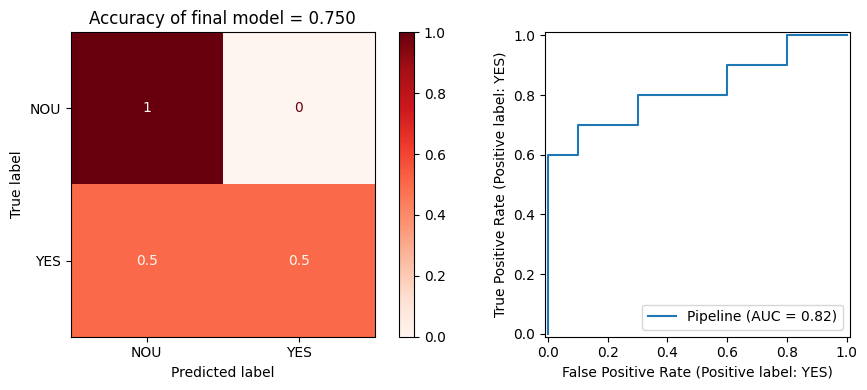

In [13]:
#| label: metrics
# Accuracy and confusion  matrix

fig, (ax, ax2) = plt.subplots(1,2, figsize=(10,4), tight_layout=True)


ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true', cmap='Reds',ax=ax)

RocCurveDisplay.from_estimator(optimized_model, X_test, y_test, ax=ax2)


title1 = (f'Accuracy of final model = {accuracy_score(y_test, y_pred):.3f}')
ax.set_title(title1)


## Feature importance

In [14]:
#| label: importdatalessfeature
# Import data
df = pd.read_csv("../data/UV_pilot.csv")

wavenumbers = [
    "3856",
    "3401",
    "3275",
    "2923",
    "2859",
    "1902",
    "1745",
    "1636",
    "1538",
    "1457",
    "1307",
    "1153",
    "1076",
    "1027",
    "881",
    "527",
    "401",
]


# Split features and target
X = df[wavenumbers]
y = df.loc[:, "Exposed"]

# Split into train and test sets

X_train, X_test, y_train, y_test = train_test_split(
    X, y, shuffle=True, stratify=y, test_size=0.2
)


In [15]:
# create a dictionary with different hyperparameters and the values you want to test

param_grid = {'model__penalty': ['l1', 'l2'],
                  'model__C': [0.01, 0.1, 1, 10],
                  'model__solver': ['liblinear', 'saga']}

# create the new pipleine with the model we choose to optimize
pipe = Pipeline([('model', LogisticRegression(max_iter=10000, class_weight='balanced'))])

In [16]:
search = GridSearchCV(pipe, param_grid, n_jobs=2)
search.fit(X_train, y_train)
print(f"Best parameter (CV score={search.best_score_:.2f})")
print(search.best_params_)

Best parameter (CV score=0.56)
{'model__C': 1, 'model__penalty': 'l2', 'model__solver': 'liblinear'}


In [17]:
#| label: optimal
optimized_model = search.best_estimator_
optimized_model.fit(X_train, y_train)

Pipeline(steps=[('model',
                 LogisticRegression(C=1, class_weight='balanced',
                                    max_iter=10000, solver='liblinear'))])

In [18]:
#| label: coeff
# accessing the model coefficients
optimized_model.named_steps['model'].coef_

array([[-0.01086563, -0.06647627, -0.04028753,  0.03905258,  0.04798557,
        -0.0115063 ,  0.02188028,  0.02296419,  0.04247399,  0.03510987,
         0.03820413, -0.08391647,  0.07831322,  0.01641863, -0.04101555,
        -0.07048381, -0.13402034]])

In [19]:
#| label: featuredf
feature_importance = pd.DataFrame()
feature_importance['Wavenumbers'] = wavenumbers
feature_importance['Coefficients'] = optimized_model.named_steps['model'].coef_.T
feature_importance['Wavenumbers'] = feature_importance['Wavenumbers'].astype('category')
feature_importance

,Wavenumbers,Coefficients
0,3856,-0.010866
1,3401,-0.066476
2,3275,-0.040288
3,2923,0.039053
4,2859,0.047986
5,1902,-0.011506
6,1745,0.021880
7,1636,0.022964
8,1538,0.042474
9,1457,0.035110


<Axes: ylabel='Wavenumbers'>

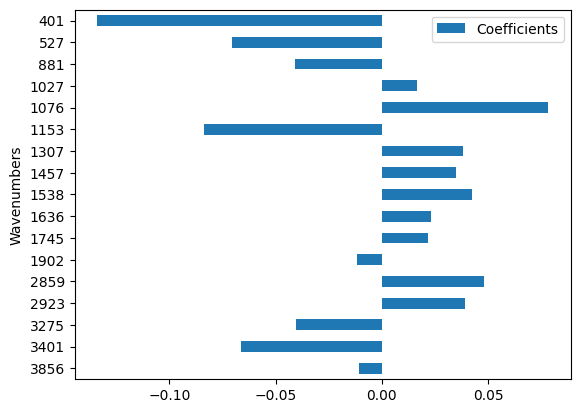

In [20]:
#| label: coeffplot
feature_importance.plot.barh(x='Wavenumbers', y='Coefficients')

In [21]:
#|label: permutation
# permutation importance
from sklearn.inspection import permutation_importance
r = permutation_importance(optimized_model, X_test, y_test,
                           n_repeats=200,
                           random_state=0, scoring='accuracy')

In [22]:
#|label: barplot
# create a series of the importances mean and add the names of the wavenumber values
forest_importances = pd.Series(r.importances_mean, index=X.columns.values)

# Barplot with sd bars
#forest_importances.plot.bar(yerr=r.importances_std)

<Axes: xlabel='Wavenumbers'>

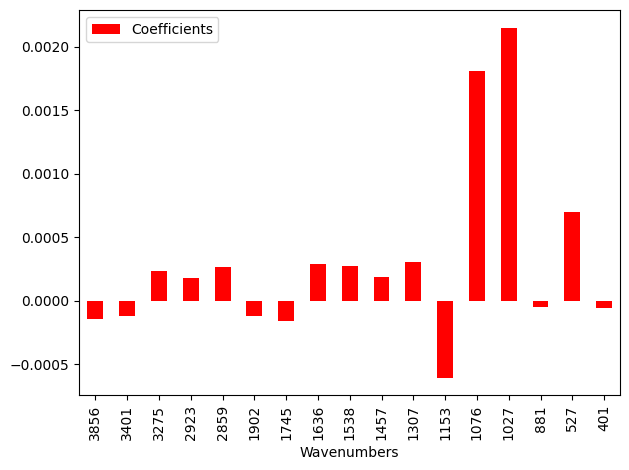

In [59]:
#|label: comparison
# comparing the two approaches

fig, ax = plt.subplots(tight_layout=True)

feature_importance.plot.bar(x='Wavenumbers', y='Coefficients', ax=ax, color='r')
#forest_importances.plot.bar(yerr=r.importances_std, ax=ax2, color='g')

In [60]:
# using random forest
pipe = Pipeline([('scaler', StandardScaler(with_std=False)), ('model', RandomForestClassifier())])
pipe.fit(X_train, y_train)
print(f"accuracy is: {accuracy_score(y_test, pipe.predict(X_test))})")

accuracy is: 0.7)


In [61]:
#| label: ftrf
pipe.named_steps['model'].feature_importances_

array([0.17093772, 0.04011147, 0.02748989, 0.06387667, 0.07254563,
       0.08291522, 0.05297084, 0.06783495, 0.05192696, 0.05611174,
       0.03902881, 0.05445541, 0.06264931, 0.04480644, 0.03412516,
       0.04047971, 0.03773409])

<Axes: xlabel='Wavenumbers'>

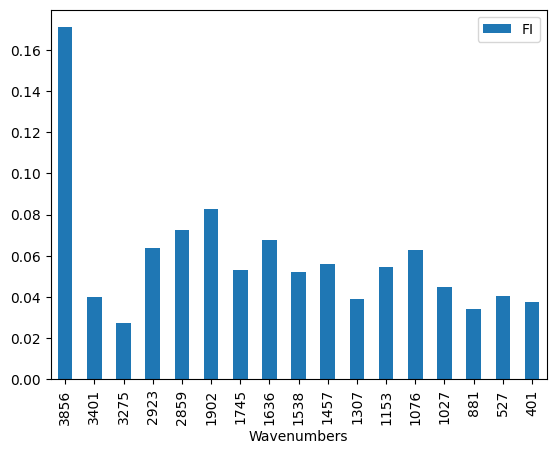

In [62]:
#|label: RFplot
feature_importance = pd.DataFrame()
feature_importance['Wavenumbers'] = wavenumbers
feature_importance['FI'] = pipe.named_steps['model'].feature_importances_
feature_importance['Wavenumbers'] = feature_importance['Wavenumbers'].astype('category')
feature_importance.plot.bar(x='Wavenumbers', y='FI')

In [63]:
# test set
r = permutation_importance(pipe, X_test, y_test,
                           n_repeats=50,
                           random_state=0, scoring='accuracy')
forest_importances = pd.Series(r.importances_mean, index=X.columns.values)

# train set
r_train = permutation_importance(pipe, 
                                  X_train, 
                                  y_train, 
                                  n_repeats=50, 
                                  random_state=0, 
                                  scoring='accuracy')


Text(0, 0.5, 'Feature importance permutation')

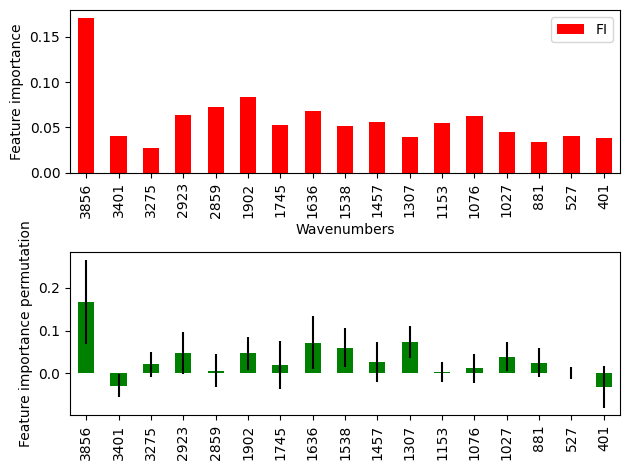

In [64]:
#|label: rfcomparison
fig, (ax, ax2) = plt.subplots(2,1, tight_layout=True)

feature_importance.plot.bar(x='Wavenumbers', y='FI', ax=ax, color='r')
forest_importances.plot.bar(yerr=r.importances_std, ax=ax2, color='g')
ax.set_ylabel('Feature importance')
ax2.set_ylabel('Feature importance permutation')

In [65]:
# test
sorted_importances_idx = r.importances_mean.argsort()
importances = pd.DataFrame(
    r.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx])

# train
sorted_importances_idx_train = r_train.importances_mean.argsort()
importances_train = pd.DataFrame(
    r_train.importances[sorted_importances_idx_train].T,
    columns=X.columns[sorted_importances_idx_train])


print(importances.head(2))
print(importances_train.head(2))

    401  3401  527  1153  2859  1076  1745  3275  881  1457  1027  2923  1902  \
0 -0.05 -0.05  0.0   0.0 -0.05   0.0 -0.05  0.00  0.0  0.05   0.0 -0.05  0.05   
1 -0.10  0.00  0.0   0.0  0.05   0.0  0.00  0.05  0.0  0.00   0.1  0.05  0.00   

   1538  1636  1307  3856  
0  0.05   0.1  0.05  0.30  
1  0.10   0.1  0.10  0.15  
   3275  2859  881  1307  1902  3401  1745  527  401  2923  1153    1538  \
0   0.0   0.0  0.0   0.0   0.0   0.0   0.0  0.0  0.0   0.0   0.0  0.0125   
1   0.0   0.0  0.0   0.0   0.0   0.0   0.0  0.0  0.0   0.0   0.0  0.0000   

     1636    1457   1027    1076    3856  
0  0.0125  0.0125  0.025  0.0250  0.1375  
1  0.0000  0.0125  0.025  0.0125  0.1750  


Text(0.5, 1.0, 'Permutation Importances (train set)')

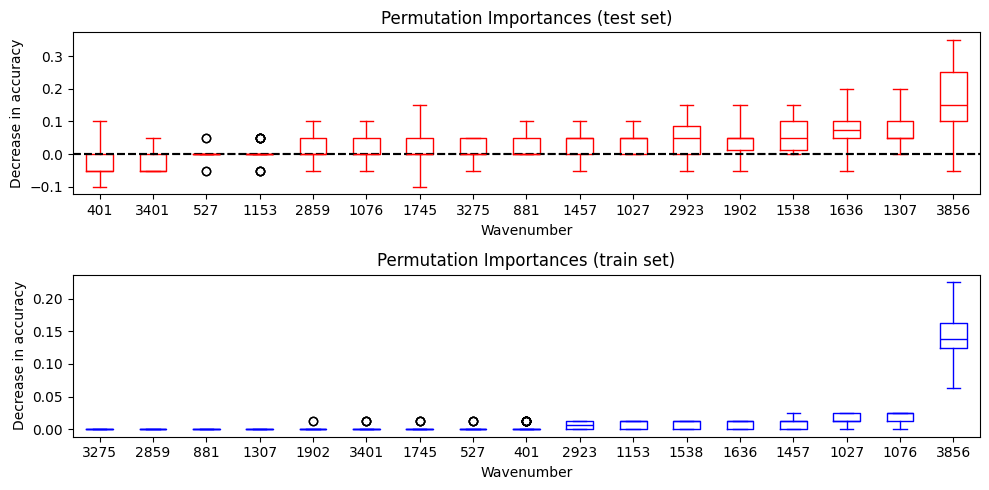

In [66]:
#|label: finalplot
fig, (ax, ax2) = plt.subplots(2,1,figsize=(10,5), tight_layout=True)
importances.plot.box(vert=True, whis=10, ax=ax, color='r')
ax.axhline(0, ls='--', color='k')

importances_train.plot.box(vert=True, whis=10, ax=ax2, color='b')
ax.axhline(0, ls='--', color='k')


ax.set_xlabel("Wavenumber")
ax.set_ylabel("Decrease in accuracy")
ax.set_title("Permutation Importances (test set)")

ax2.set_xlabel("Wavenumber")
ax2.set_ylabel("Decrease in accuracy")
ax2.set_title("Permutation Importances (train set)")